In [47]:
%matplotlib inline
import sys
sys.path.insert(0, 'Resources/MagicCube/code/')
import matplotlib.pyplot as plt
import random as rd
from bitstring import BitArray
import math
import copy
import tensorflow as tf
import random
import pickle

from cube import *
from utils import *

In [48]:
N = 3 #cube size

#Q-learning parameters
r = 0.15
gamma = 1 / (1 + r) #discount of the model
C = 1.
epsilon = 0.05
beta = 3./4 

In [49]:
def all_actions(N): #rotate by +90° / by -90° 
    actions = []
    c = Cube(N)
    for face_name in ["F","U","R"]: #the list is in the end ['U','D','F']
        for layer in range(c.N):
            for times in [1,-1]:
                actions.append([face_name,layer,times])
    return actions

# def reward_cube(c):
#     edges = computeEdges(c)
#     corners = computeCorners(c)
#     ncf = numCompleteFaces(c)
#     nce = numCompleteEdges(c,edges)
#     ncc = numCompleteCorners(c,corners)
    
# #     return (-1 + 10*ncf + 2*nce + 3*ncc + 100*(ncf == 6))/700
#     return (ncf == 6)

def reward_cube(c):
    ncf = numCompleteFaces(c)
    return (-1 + entropy(c) + 100*(ncf == 6))/100

def entropy(c):
    ent = 0
    for f in range(6):
        pi = len(np.unique(c.stickers[f]))
        ent -= pi*np.log(pi)       
    return ent
        

def state_cube(c):
    #determining the new state
    edges = computeEdges(c)
    corners = computeCorners(c)
    edges_state = []
    corners_state = []
    faces_state = []
#     for e in edges:
#         edges_state.append(e.isDone(c))
    for corner in corners:
        corners_state.append(corner.isDone(c))
    nFaces = 6
    for f in range(nFaces):
        faces_state.append(np.sum(c.stickers[f] != c.stickers[f,0,0]) == 0)
#     #conversion from binary list to int
#     e = BitArray(edges_state).uint
    c = BitArray(corners_state).uint
    f = BitArray(faces_state).uint
#     ncf = numCompleteFaces(c)
#     nce = numCompleteEdges(c,edges)
#     ncc = numCompleteCorners(c,corners)
#     return ncf,nce,ncc
    return c,f

def test_function_state_cube():
    c = Cube(3)
    print(state_cube(c))
    c.randomize(1)
    print(state_cube(c))

In [50]:
actions = all_actions(N) #rotate by +90° / by -90° 
nb_actions = len(actions)
actions

[['F', 0, 1],
 ['F', 0, -1],
 ['F', 1, 1],
 ['F', 1, -1],
 ['F', 2, 1],
 ['F', 2, -1],
 ['U', 0, 1],
 ['U', 0, -1],
 ['U', 1, 1],
 ['U', 1, -1],
 ['U', 2, 1],
 ['U', 2, -1],
 ['R', 0, 1],
 ['R', 0, -1],
 ['R', 1, 1],
 ['R', 1, -1],
 ['R', 2, 1],
 ['R', 2, -1]]

In [51]:
class network():
    
    def __init__(self,W1,W2):
        
        self.W1 = W1
        self.W2 = W2
        
        self.Q1 = tf.matmul(x/6,self.W1)# + b1
        self.Qs1 = tf.nn.tanh(self.Q1)
        self.Q2 = tf.matmul(self.Qs1,self.W2)#tf.nn.relu(tf.matmul(Qs1,W2))# + b2)
        
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
         
        self.network_params = tf.trainable_variables()
        self.tau = 1.
    
    
    
    def update_target_network(self, trainNet):
        
        self.update_target_network_params = \
            [self.network_params[i].assign(tf.mul(trainNet.network_params[i], self.tau) + \
                tf.mul(self.network_params[i], 1. - self.tau))
                for i in range(len(self.network_params))]
        
        self.sess.run(self.update_target_network_params)

In [52]:
c_init=Cube(3)

# resume = sys.argv[1] == "True"
resume = True

# sess = tf.InteractiveSession()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
with tf.device("/cpu:0"):

    x = tf.placeholder(tf.float32, shape=[None,6*c_init.N**2])
    Q_ = tf.placeholder(tf.float32, shape=[None,nb_actions])
    n_layers = 1

    if not resume:
        middle_layer = 500
        W1 = tf.Variable(tf.random_normal([6*c_init.N**2,middle_layer], stddev=1e-2))
        b1 = tf.Variable(tf.random_normal([middle_layer], stddev=1e-2))

        W2 = tf.Variable(tf.random_normal([middle_layer,nb_actions], stddev=1e-2))
        b2 = tf.Variable(tf.random_normal([nb_actions], stddev=1e-2)) 

        for i in range(n_layers):
            globals()['Wm_%s'%i] = tf.Variable(tf.random_normal([middle_layer,middle_layer], stddev=1e-2))
            globals()['bm_%s'%i]  = tf.Variable(tf.random_normal([middle_layer], stddev=1e-2)) 
        
    else:
        load = pickle.load(open('save.p', 'rb'))
        W1 = tf.Variable(load[0])
        W2 = tf.Variable(load[1])
        b1 = tf.Variable(load[2])
        b2 = tf.Variable(load[3])
        n_layers = len(load[4])
        for i in range(n_layers):
            globals()['Wm_%s'%i] = tf.Variable(load[4][i])
            globals()['bm_%s'%i]  = tf.Variable(load[5][i])


    Q1 = tf.nn.tanh(tf.matmul(x/6,W1) + b1)
    
    Qm_0 = tf.nn.tanh(tf.matmul(Q1,Wm_0) + bm_0)
    
    for i in range(1,n_layers):
        
        globals()['Qm_%s'%i] = tf.nn.tanh(tf.matmul(globals()['Qm_%s'%(i-1)],globals()['Wm_%s'%i]) + globals()['bm_%s'%i])
        
        
    Q2 = tf.matmul(globals()['Qm_%s'%(n_layers-1)],W2) + b2 #tf.nn.relu(tf.matmul(Qs1,W2))# + b2)
    # Qs = tf.matmul(Q2,act)
    Qs = Q2

    
    loss_function = tf.reduce_mean(tf.square(tf.sub(Q_,Qs)))

    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)

In [53]:
def DQN(c_init,Tmax,nb_episodes, n_moves):
    
    done = 0
    lActions = np.zeros(18)
    print("moves","\t","ep.","\t","Loss Function","\t","Min Q","\t\t", "Reward", "", "NB.","\t", "Prcent.")
    
    with tf.device("/gpu:0"):
        train_step = tf.train.RMSPropOptimizer(0.002).minimize(loss_function)
        sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))
        
    mineps = 10./100
    epssteps = 1e6
    def eps(episode):
        return 1-(1-mineps)*min(1,episode/(epssteps))
    
    percentDone = np.array([0])
    percentDoneMean = np.array([0])

    episode = 1
    
    tries = 1
    
    dones = np.empty([0])
    
    D = []
    
    while percentDoneMean[-1] < .95 and episode < nb_episodes:  
        
        episode += 1
        
        s = copy.deepcopy(c_init)
        s.randomize(n_moves) #we randomize n_moves times in order to have a "well mixed" cube
        #s.move("R",2,-1)
        cum_reward = []
        
        tries += 1
        done = 0
            
        for i in range(Tmax):
            
            #Choose an action by greedily (with e chance of random action) from the Q-network
            S = copy.deepcopy(np.reshape(s.stickers,(1, 54)))
            Qout = sess.run(Q2,feed_dict={x:S})
            if(rd.random() > eps(episode)):
                a = np.argmax(Qout)
            else:
                a = rd.randint(0,nb_actions-1)

            lActions[a] += 1
            
            #print(actions[a])
            #print(Qout)
            #Get new state and reward from environment
            f,l,d = actions[a]
            #print(actions[a])
            s.move(f,l,d)            
            r = reward_cube(s)
            cum_reward.append(r)
            D.append(copy.deepcopy([S, a, r, np.reshape(s.stickers,(1, 54)) , numCompleteFaces(s)]))
            
            #print(S)
            #print(np.reshape(s.stickers,(1, 54)))
            
            #Obtain the Q' values by feeding the new state through our network
#==============================================================================
#            Qprime = sess.run(Q2,feed_dict={x:np.reshape(s.stickers,(1, 54))})
             #Obtain maxQ' and set our target value for chosen action.
#            maxQprime = np.max(Qprime)
#            targetQ = Qout
#            targetQ[0,a] = r + gamma*maxQprime
             #Train our network using target and predicted Q values
#                
#             sess.run(train_step,feed_dict={Q_: targetQ, x: S})
#==============================================================================
            
            #print(targetQ)

            
# ============================================================================== 
#                           EXPERIENCE REPLAY      
# ==============================================================================
    
    
            if len(D) == 16: # BATCH SIZE by Guillaume Lample
                batch = copy.deepcopy(np.array(D))
                random.shuffle(batch)
                tts = np.empty([0,nb_actions])
                
                for i in range(len(batch)):
                  
                    faces_done = batch[i][-1]
                    Qprime = sess.run(Q2,feed_dict={x:batch[i][-2]})
                    maxQprime = np.max(Qprime)
                    
                    tt = sess.run(Q2,feed_dict={x:batch[i][0]})
                    if faces_done >= 6:
                        tt[0,batch[i][1]] = batch[i][-3]
                    else:
                        tt[0,batch[i][1]] = batch[i][-3] + gamma*maxQprime
                  
                    tts = np.concatenate((tts,tt),0)
                  
                sess.run(train_step,feed_dict={Q_: tts, x: np.vstack(batch[:,0])})
                
                D = []
    
# ============================================================================== 
#                           
# ==============================================================================

            if numCompleteFaces(s) == 6:
                done = 1
                break
            
        dones = np.append(dones,done)
            
        
            
#        if episode%100 == 1:
##             sess.run(loss_function,feed_dict={Q_: targetQ, x: S}),"\t",
#            print(n_moves,"\t",episode,"\t",min(sess.run(Q2,feed_dict={x:S})[0]),"\t", round(np.mean(cum_reward[-1]),2), "\t", np.sum(dones[-1000:]),"\t", round(100*np.sum(dones[-1000:])/min(1000,tries),2))
#    #             print(lActions)
#            percentDone.append(100*np.sum(dones[-1000:])/min(1000,tries))
            
        if episode%1000 == 1:
            #Evaluation of the policy
#            print("Evaluation after training: actions maximizing the reward, no more random")
            dones_evaluation = np.empty([0])
            N_iteration_evaluation = 100
            for _ in range(N_iteration_evaluation):
                done_evaluation = 0
                s = copy.deepcopy(c_init)
                while numCompleteFaces(s) == 6: #in order not to start with the solved cube
                    s.randomize(n_moves) #we randomize n_moves times in order to have a "well mixed" cube
                for i in range(Tmax):
                    S = copy.deepcopy(np.reshape(s.stickers,(1, 54)))
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    Qout = sess.run(Q2,feed_dict={x:S})
                    a = np.argmax(Qout)
                    #Get new state and reward from environment
                    f,l,d = actions[a]
                    s.move(f,l,d)   
                    if numCompleteFaces(s) == 6:
                        done_evaluation = 1
                        break
                dones_evaluation = np.append(dones_evaluation,done_evaluation)        
            print(n_moves,"\t", episode, "\t", np.round(percentDoneMean[-1],2), "\t", round(np.mean(cum_reward[-1]),2),"\t", np.sum(dones_evaluation), "\t", round(100*np.mean(dones_evaluation),2))

            percentDone = np.append(percentDone,np.mean(dones_evaluation))
            percentDoneMean = np.append(percentDoneMean, np.mean(percentDone[-10:]))
            
            plt.clf()
            plt.plot(100*percentDone, linewidth = 2, alpha = 0.5)
            plt.plot(100*percentDoneMean, linewidth = 2)
            plt.title("n_moves: "+str(n_moves))
            plt.xlabel("Nb_episodes (*1000)")
            plt.ylabel("Accuracy")
            plt.pause(0.0001)
            
        if episode%10000 == 1:
            topickle = [sess.run(W1),sess.run(W2),sess.run(b1),sess.run(b2)]
            topickle.append([sess.run(globals()['Wm_%s'%i]) for i in range(n_layers)])
            topickle.append([sess.run(globals()['bm_%s'%i]) for i in range(n_layers)])
            pickle.dump(topickle, open('save.p', 'wb'))
            
    plt.title("n_moves: "+str(n_moves)+" - "+str(int(100*percentDoneMean[-1]))+"%")
    plt.savefig("./learning_curves/n_moves_"+str(n_moves)+".png")

In [54]:
def longTrain(c_init,n_moves_max):

    for i in range(1,1+n_moves_max):
        print("==============================================================================")
        print("\t",i,"Moves","\t")
        print("==============================================================================")
        DQN(c_init=c_init,Tmax=i,nb_episodes=1000000,n_moves = i)

In [113]:
def success(n_max):

    with tf.device("/cpu:0"):
        load = pickle.load(open('save.p', 'rb'))
        W1 = tf.Variable(load[0])
        W2 = tf.Variable(load[1])
        b1 = tf.Variable(load[2])
        b2 = tf.Variable(load[3])
        n_layers = len(load[4])
        for i in range(n_layers):
            globals()['Wm_%s'%i] = tf.Variable(load[4][i])
            globals()['bm_%s'%i]  = tf.Variable(load[5][i])
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        
    percentages = np.empty([0])

    for n_moves in range(1,n_max):

        dones_evaluation = np.empty([0])
        N_iteration_evaluation = 1000
        for _ in range(N_iteration_evaluation):
            done_evaluation = 0
            s = copy.deepcopy(Cube(3))
            while numCompleteFaces(s) == 6: #in order not to start with the solved cube
                s.randomize(n_moves) #we randomize n_moves times in order to have a "well mixed" cube
            for i in range(n_moves):
                S = copy.deepcopy(np.reshape(s.stickers,(1, 54)))
                #Choose an action by greedily (with e chance of random action) from the Q-network
                Qout = sess.run(Q2,feed_dict={x:S})
                a = np.argmax(Qout)
                #Get new state and reward from environment
                f,l,d = actions[a]
                s.move(f,l,d)   
                if numCompleteFaces(s) == 6:
                    done_evaluation = 1
                    break

            dones_evaluation = np.append(dones_evaluation,done_evaluation)

        percentages = np.append(percentages, np.mean(dones_evaluation))
    
#     plt.plot(range(1,n_max), 100*percentages)
    
    return 100*percentages

In [139]:
results = np.vstack((results,success(n_max)))

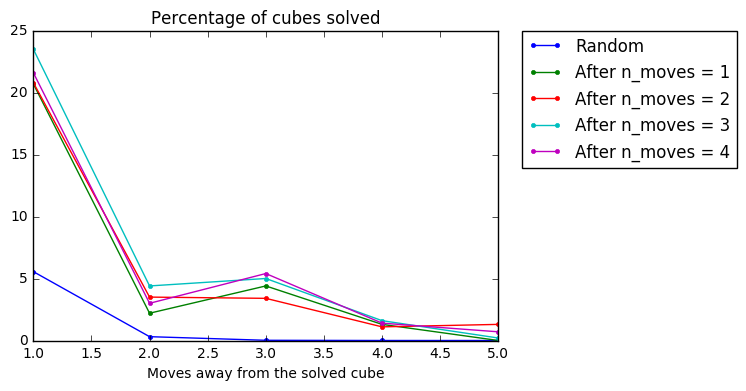

In [140]:
for i in range(len(results)):    
    plt.plot(range(1,n_max), results[i], ".-", label = labels[i])
plt.xlim(xmin = 1, xmax = 5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Percentage of cubes solved")
plt.xlabel('Moves away from the solved cube')
plt.show()

In [85]:
labels = ["Random", "After n_moves = 1", "After n_moves = 2", "After n_moves = 3", "After n_moves = 4"]

In [110]:
n_max = 5
results = np.array([[100/(18**i) for i in range(1,n_max)]])

In [98]:
results = results[:-1]

''

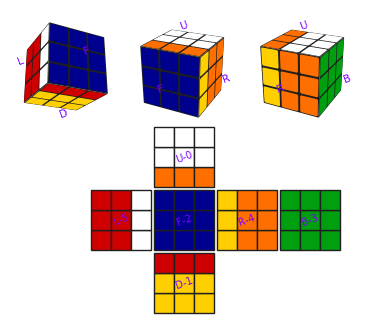

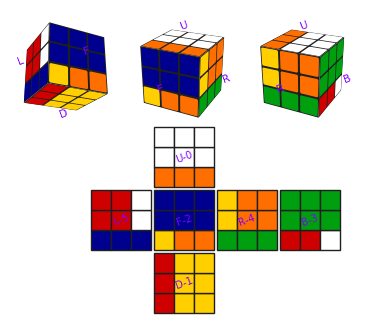

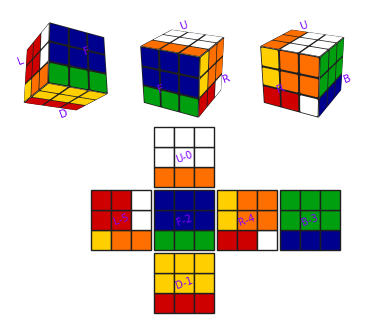

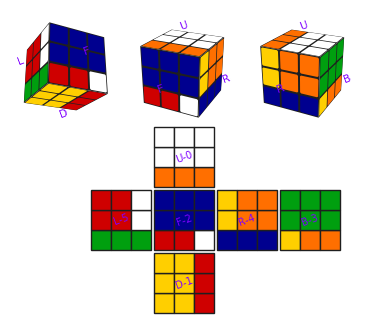

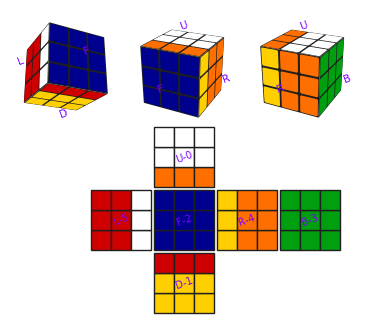

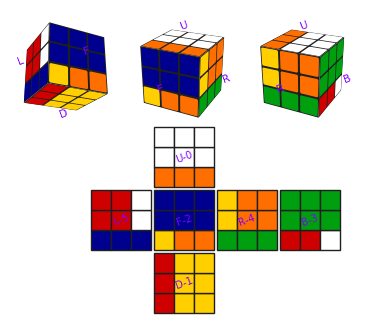

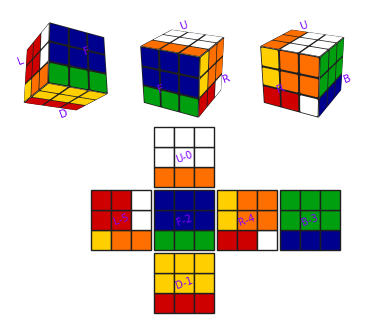

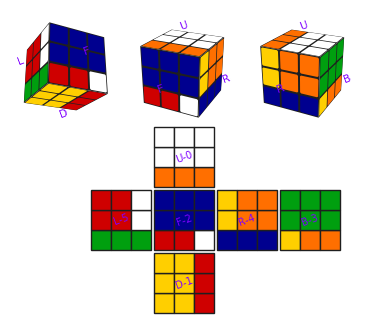

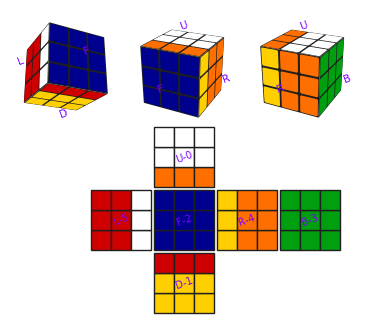

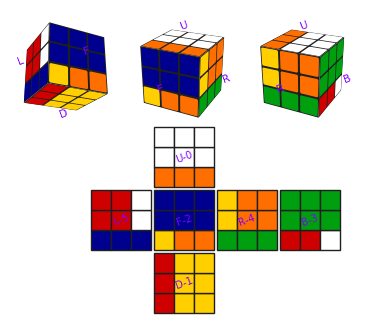

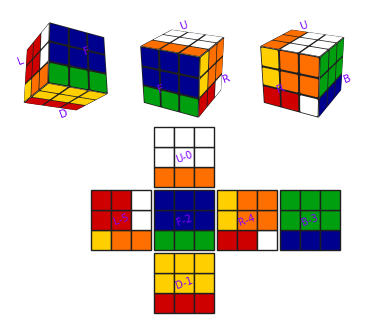

In [136]:
n_moves = 1
s = copy.deepcopy(Cube(3))
while numCompleteFaces(s) == 6: #in order not to start with the solved cube
    s.randomize(n_moves) #we randomize n_moves times in order to have a "well mixed" cube
for i in range(10*n_moves):
    s.render()
    S = copy.deepcopy(np.reshape(s.stickers,(1, 54)))
    #Choose an action by greedily (with e chance of random action) from the Q-network
    Qout = sess.run(Q2,feed_dict={x:S})
    a = np.argmax(Qout)
    #Get new state and reward from environment
    f,l,d = actions[a]
    s.move(f,l,d)   
    if numCompleteFaces(s) == 6:
        break

s.render()
""

0.99
-0.0654517744448
-0.14183347464


''

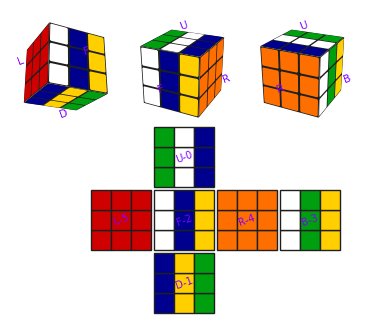

In [36]:
c = Cube(3)
print(reward_cube(c))
c.randomize(1)
print(reward_cube(c))
c.randomize(1)
print(reward_cube(c))
c.render()
""

In [ ]:
# with tf.device("/gpu:0"):
#     longTrain(Cube(3),10)
# #    DQN(c_init=Cube(3),Tmax=int(sys.argv[4]),nb_episodes=int(sys.argv[2]),n_moves = int(sys.argv[3]))

In [ ]:
# topickle = [sess.run(W1),sess.run(W2)]
# pickle.dump(topickle, open('save.p', 'wb'))

In [ ]:
# init = tf.initialize_all_variables()

# # Set learning parameters
# y = .99
# e = 0.1
# num_episodes = 2000
# #create lists to contain total rewards and steps per episode
# jList = []
# rList = []
# with tf.Session() as sess:
#     sess.run(init)
#     for i in range(num_episodes):
#         #Reset environment and get first new observation
#         s = env.reset()
#         rAll = 0
#         d = False
#         j = 0
#         #The Q-Network
#         while j < 99:
#             j+=1
#             #Choose an action by greedily (with e chance of random action) from the Q-network
#             a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
#             if np.random.rand(1) < e:
#                 a[0] = env.action_space.sample()
#             #Get new state and reward from environment
#             s1,r,d,_ = env.step(a[0])
#             #Obtain the Q' values by feeding the new state through our network
#             Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
#             #Obtain maxQ' and set our target value for chosen action.
#             maxQ1 = np.max(Q1)
#             targetQ = allQ
#             targetQ[0,a[0]] = r + y*maxQ1
#             #Train our network using target and predicted Q values
#             _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
#             rAll += r
#             s = s1
#             if d == True:
#                 #Reduce chance of random action as we train the model.
#                 e = 1./((i/50) + 10)
#                 break
#         jList.append(j)
#         rList.append(rAll)
# print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"

In [ ]:
# # Taken from https://gist.github.com/awjuliani/fffe41519166ee41a6bd5f5ce8ae2630#file-double-dueling-dqn-tutorial-ipynb

# with tf.Session() as sess:
#     if load_model == True:
#         print 'Loading Model...'
#         ckpt = tf.train.get_checkpoint_state(path)
#         saver.restore(sess,ckpt.model_checkpoint_path)
#     sess.run(init)
#     updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
#     for i in range(num_episodes):
#         episodeBuffer = experience_buffer()
#         #Reset environment and get first new observation
#         s = env.reset()
#         s = processState(s)
#         d = False
#         rAll = 0
#         j = 0
#         #The Q-Network
#         while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
#             j+=1
#             #Choose an action by greedily (with e chance of random action) from the Q-network
#             if np.random.rand(1) < e or total_steps < pre_train_steps:
#                 a = np.random.randint(0,4)
#             else:
#                 a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
#             s1,r,d = env.step(a)
#             s1 = processState(s1)
#             total_steps += 1
#             episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
#             if total_steps > pre_train_steps:
#                 if e > endE:
#                     e -= stepDrop
                
#                 if total_steps % (update_freq) == 0:
#                     trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
#                     #Below we perform the Double-DQN update to the target Q-values
#                     Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
#                     Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
#                     end_multiplier = -(trainBatch[:,4] - 1)
#                     doubleQ = Q2[range(batch_size),Q1]
#                     targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
#                     #Update the network with our target values.
#                     _ = sess.run(mainQN.updateModel, \
#                         feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
#                     updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
#             rAll += r
#             s = s1
            
#             if d == True:

#                 break
        
#         #Get all experiences from this episode and discount their rewards.
#         myBuffer.add(episodeBuffer.buffer)
#         jList.append(j)
#         rList.append(rAll)
#         #Periodically save the model. 
#         if i % 1000 == 0:
#             saver.save(sess,path+'/model-'+str(i)+'.cptk')
#             print "Saved Model"
#         if len(rList) % 10 == 0:
#             print total_steps,np.mean(rList[-10:]), e
#     saver.save(sess,path+'/model-'+str(i)+'.cptk')
# print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"

In [111]:
### BACKUP DON'T TOUCH PLEASE ###


# def DQN(c_init,Tmax,nb_episodes, n_moves):
    
#     done = 0
#     lActions = np.zeros(18)
#     print("ep.","\t","Loss Function","\t","Min Q","\t\t", "Reward", "", "NB.","\t", "Prcent.")
#     def eps(episode):
#         return min(1,max(.05,100/(1+episode)))
    
#     episode = 1
#     tries = 0
    
#     for k in range(nb_episodes):  
        
#         s = copy.deepcopy(c_init)
#         s.randomize(n_moves) #we randomize n_moves times in order to have a "well mixed" cube
#         cum_reward = []
        
#         tries += 1
        
#         for i in range(Tmax):
            
#             #transition 
#             S = np.reshape(s.stickers,(1, 54))
#             if(rd.random() > eps(episode)):
#                 a = np.argmax(Q2.eval({x:S}))
#             else:
#                 a = rd.randint(0,nb_actions-1)

#             lActions[a] += 1
#             f,l,d = actions[a]
#             s.move(f,l,d)            
#             R = reward_cube(s)
#             cum_reward.append(R)
#             D.append([S, a, R, np.reshape(s.stickers,(1, 54))])
            
#             if numCompleteFaces(s) == 6:
#                 done += 1
                
#                 Dshuf = D
#                 random.shuffle(Dshuf)
#                 batch = np.array(Dshuf[:10])

#                 tts = np.empty([0,1])

#                 for i in range(len(batch)):

#                     faces_done = np.sum([np.sum([batch[i][-1][0][f*9+j] != batch[i][-1][0][f*9] for j in range(9)]) == 0 for f in range(6)])

#                     if faces_done == 6:
#                         tt = batch[i][-2]
#                     else:
#                         tt = batch[i][-2] + gamma*max(Q2.eval({x:batch[i][-1]})[0])

#                     tts = np.append(tts,tt)

#                 tts = np.reshape(tts,(-1, 1))

#                 action = np.reshape([[i == batch[j,1] for i in range(nb_actions)] for j in range(len(batch))], (-1,len(batch)))
#                 train_step.run(feed_dict={Q_: tts, x: batch[:,0][0], act: action})
                
        
# #         if episode%10 == 1:
#                 print(episode,"\t",loss_function.eval({Q_: tts, x:batch[:,0][0], act: action}),"\t",min(Q2.eval({x:batch[:,0][0]})[0]),"\t", round(cum_reward[-1],2), "\t", done,"\t", round(100*done/tries,2))
#         #             print(lActions)
#                 print(np.var(Q2.eval({x:batch[:,0][0]})[0]))
            
#                 break
